In [1]:
import torch
import pickle

from torchvision import transforms

# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from inertia_AE.models import inertiaAE32, reconstruction_loss, prediction_loss
from data.dspritesbT import dSpriteBackgroundDatasetTime

In [2]:
n_latent = 4

gamma_values = np.linspace(0, 1, 6)

vae = list()
training_stats = list()
for ii,gamma in enumerate(gamma_values):
    
    trainedpath = 'trained/inertiaae32_nlatent=%s_gamma=%s_dspritesT_circle_last_500K' % (n_latent,gamma)
    trainstatspath = 'trained/inertiaae32_nlatent=%sgamma=%s_dspritesT_circle_500K.pkl' % (n_latent,gamma)
    
    vae.append(inertiaAE32(n_latent = n_latent, gamma=gamma))
#     checkpoint = torch.load(trainedpath)
#     vae[ii].load_state_dict(checkpoint['model_states']['net'])
# 
#     training_stats.append(pickle.load(open(trainstatspath, 'rb')))
print(gamma_values)

[0.  0.2 0.4 0.6 0.8 1. ]


In [3]:
vae[0]

inertiaAE32(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_enc_mu): Linear(in_features=256, out_features=4, bias=True)
  (fc_enc_mu_pred): Linear(in_features=256, out_features=4, bias=True)
  (fc_dec): Linear(in_features=4, out_features=256, bias=True)
  (convT4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [4]:
dt = dSpriteBackgroundDatasetTime(transform=transforms.Resize((32,32)),
                                   shapetype='circle',data_dir='data/dsprites-dataset/')

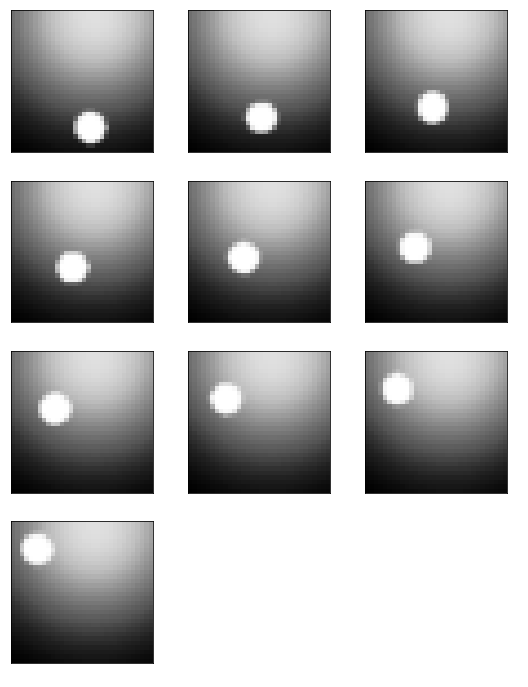

In [5]:
from data.dspritesb import show_images_grid
show_images_grid(dt[3][0])

In [6]:
vae[0].n_frames

10

torch.Size([25, 10, 1, 32, 32])


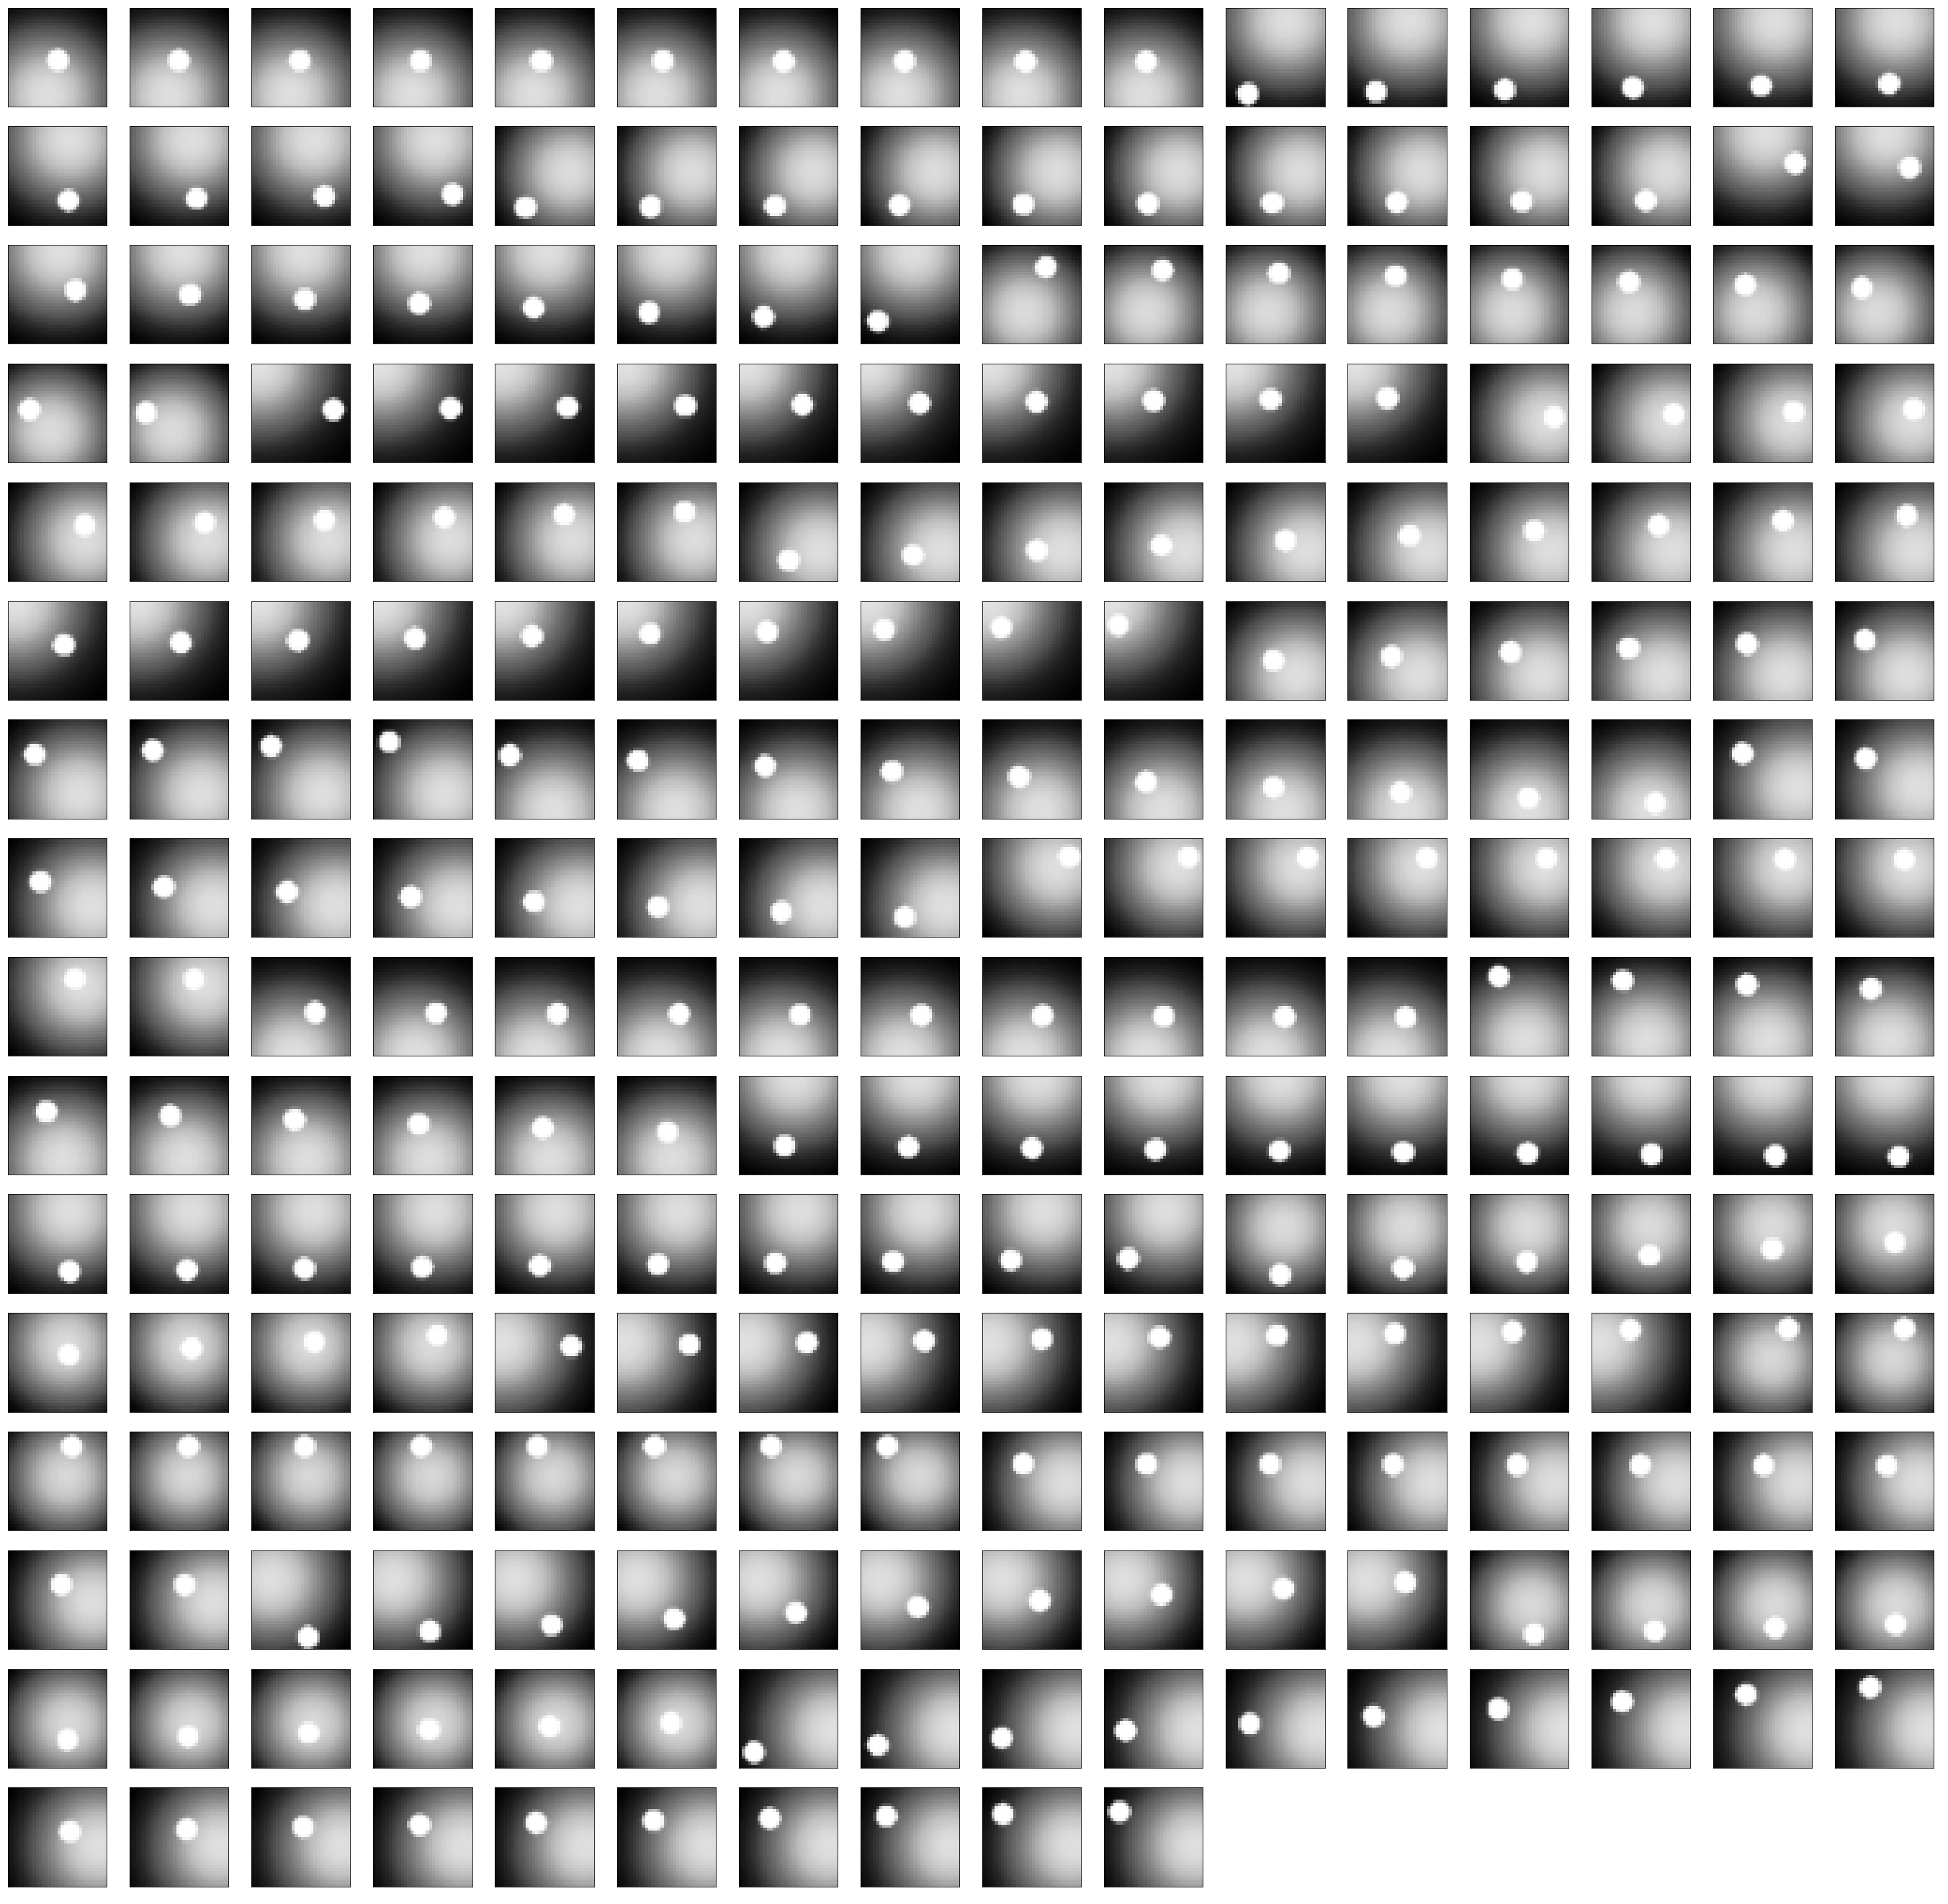

In [7]:
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dt, batch_size=25,shuffle=True, num_workers=4)
for i,[samples,latents] in enumerate(dataloader):
    print(samples.shape)
    show_images_grid(samples.view(25*10,1,32,32))
    break
x = samples

In [8]:
x.shape

torch.Size([25, 10, 1, 32, 32])

In [9]:
x.view(vae[0].n_frames*x.size(0),vae[0].img_channels,32,32).shape

torch.Size([250, 1, 32, 32])

In [10]:
x1=vae[0].conv1(x.view(vae[0].n_frames*x.size(0),vae[0].img_channels,32,32))
x1.shape
x4=vae[0].conv4(vae[0].conv3(vae[0].conv2(x1)))
x4.shape

torch.Size([250, 64, 2, 2])

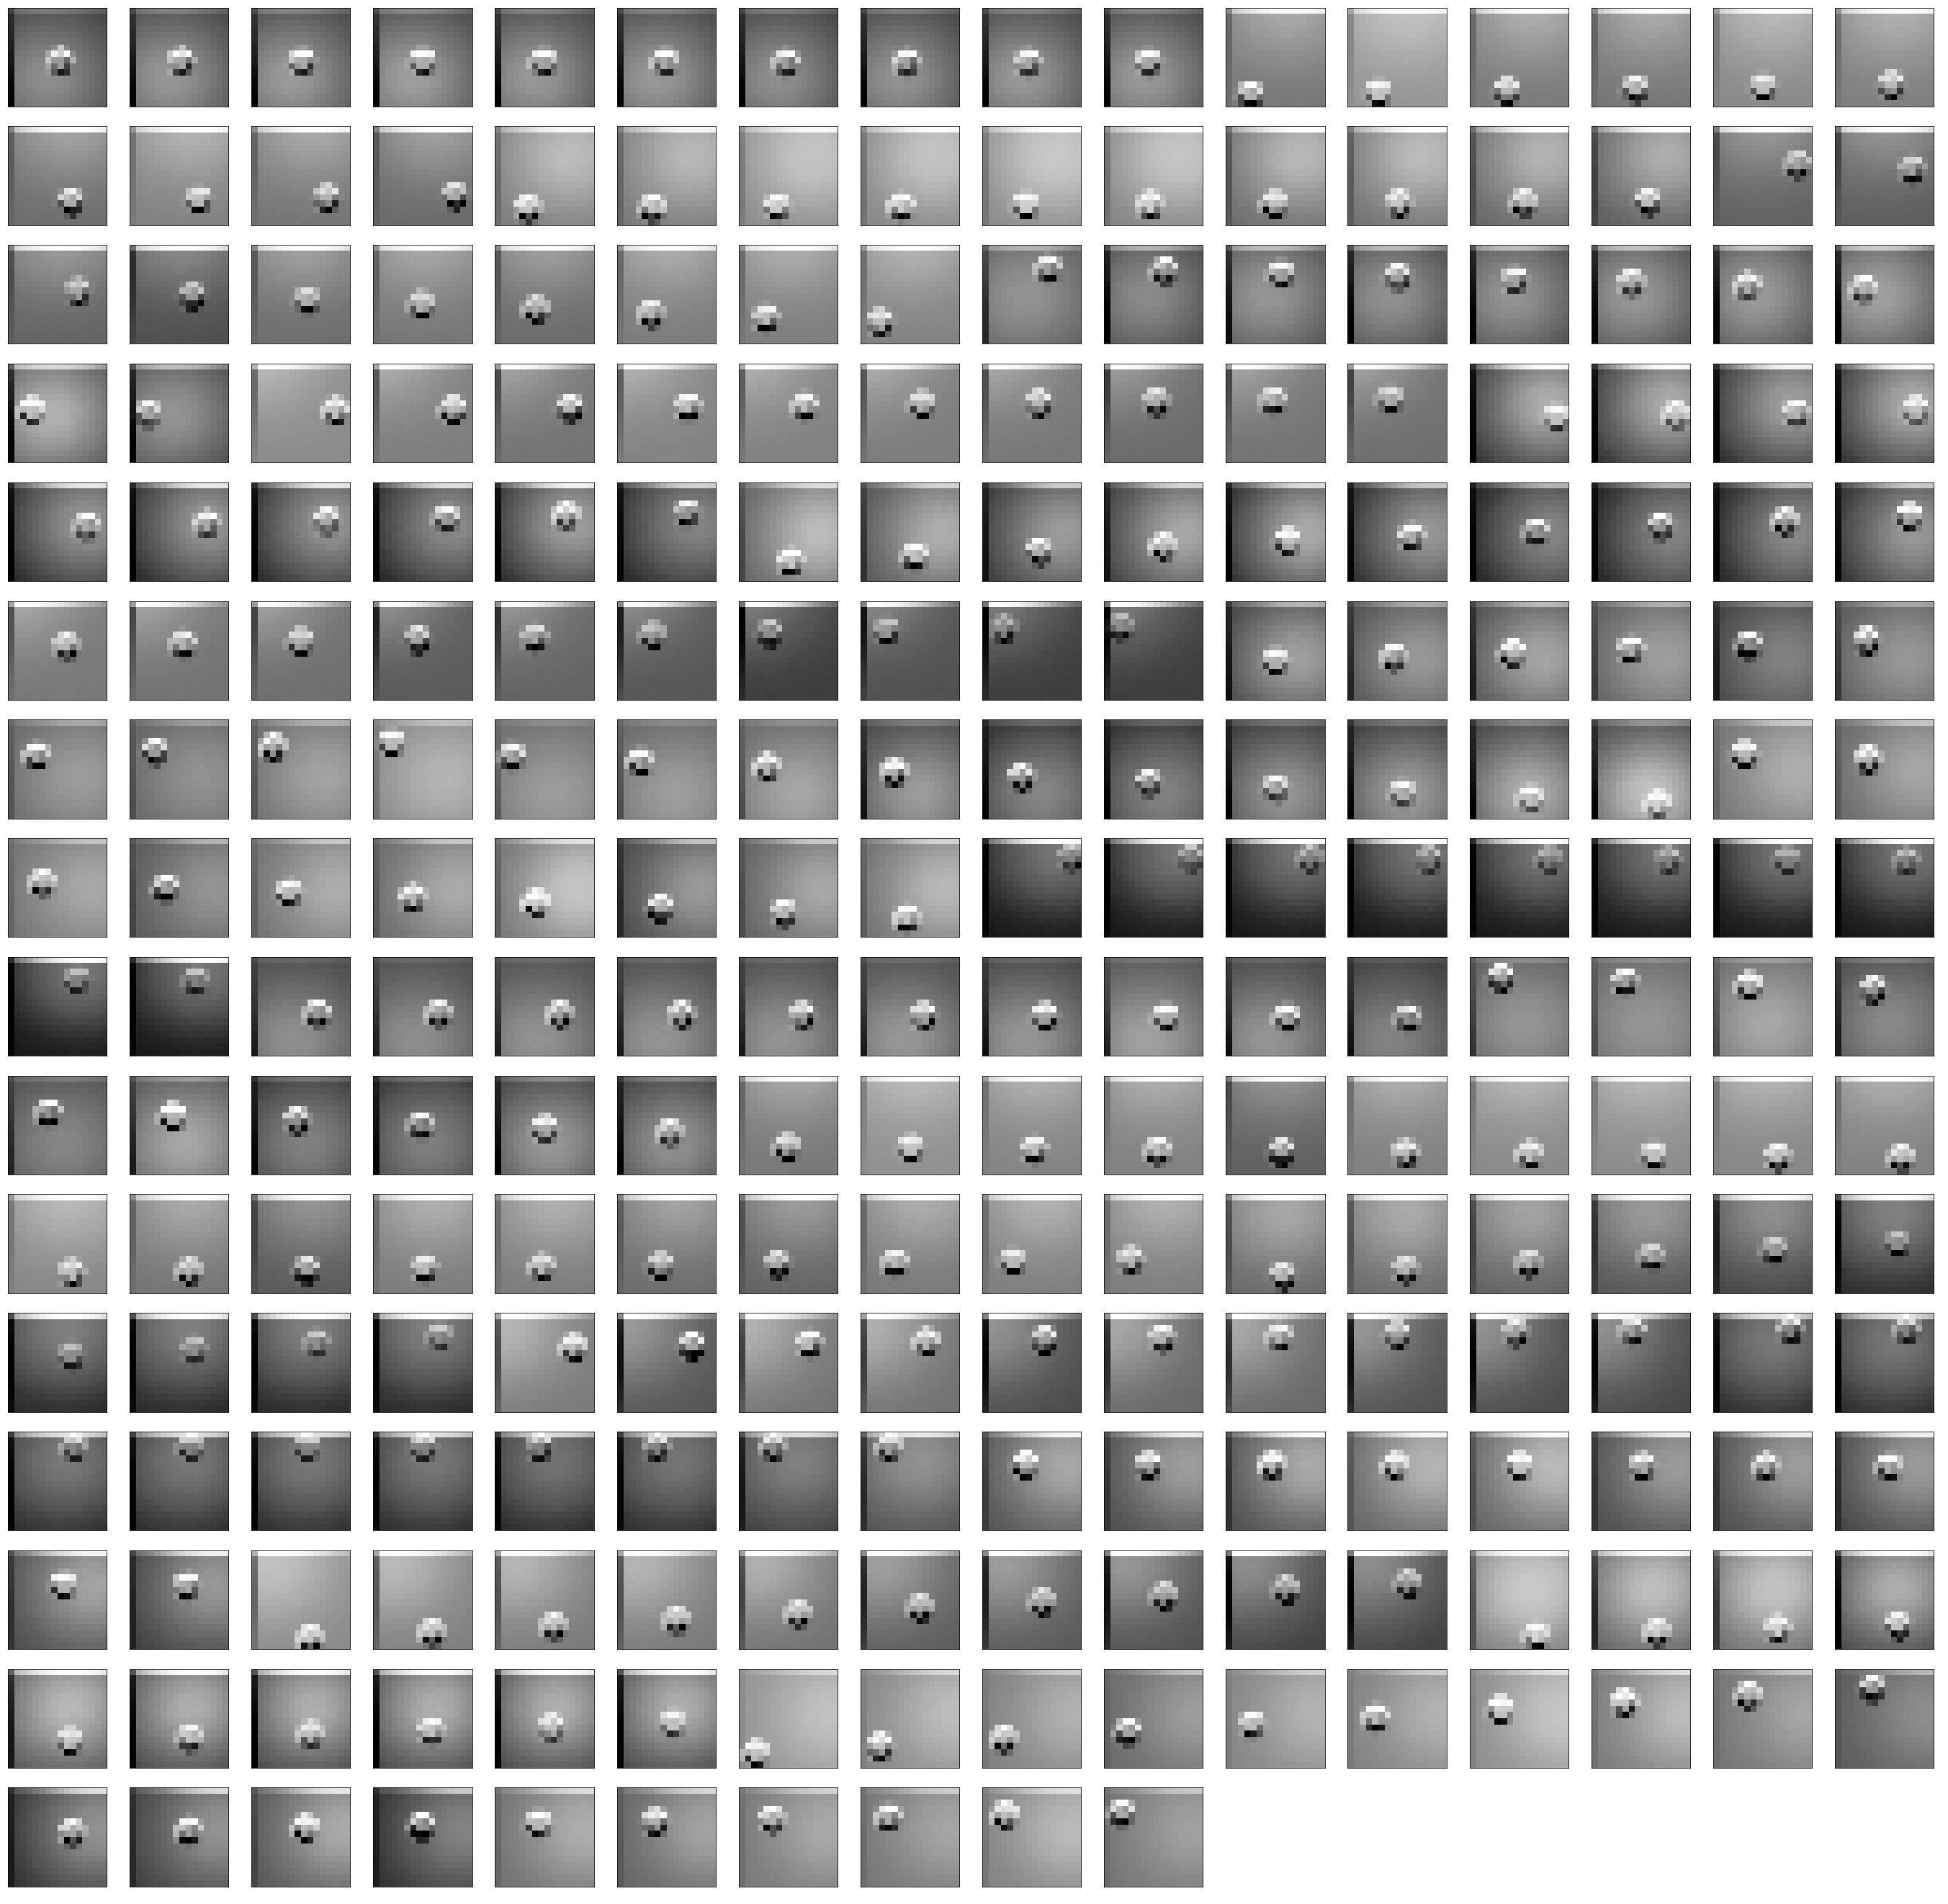

In [11]:
x1show = x1[:,0,:,:].view(-1,1,16,16).detach().numpy()
show_images_grid(x1show)

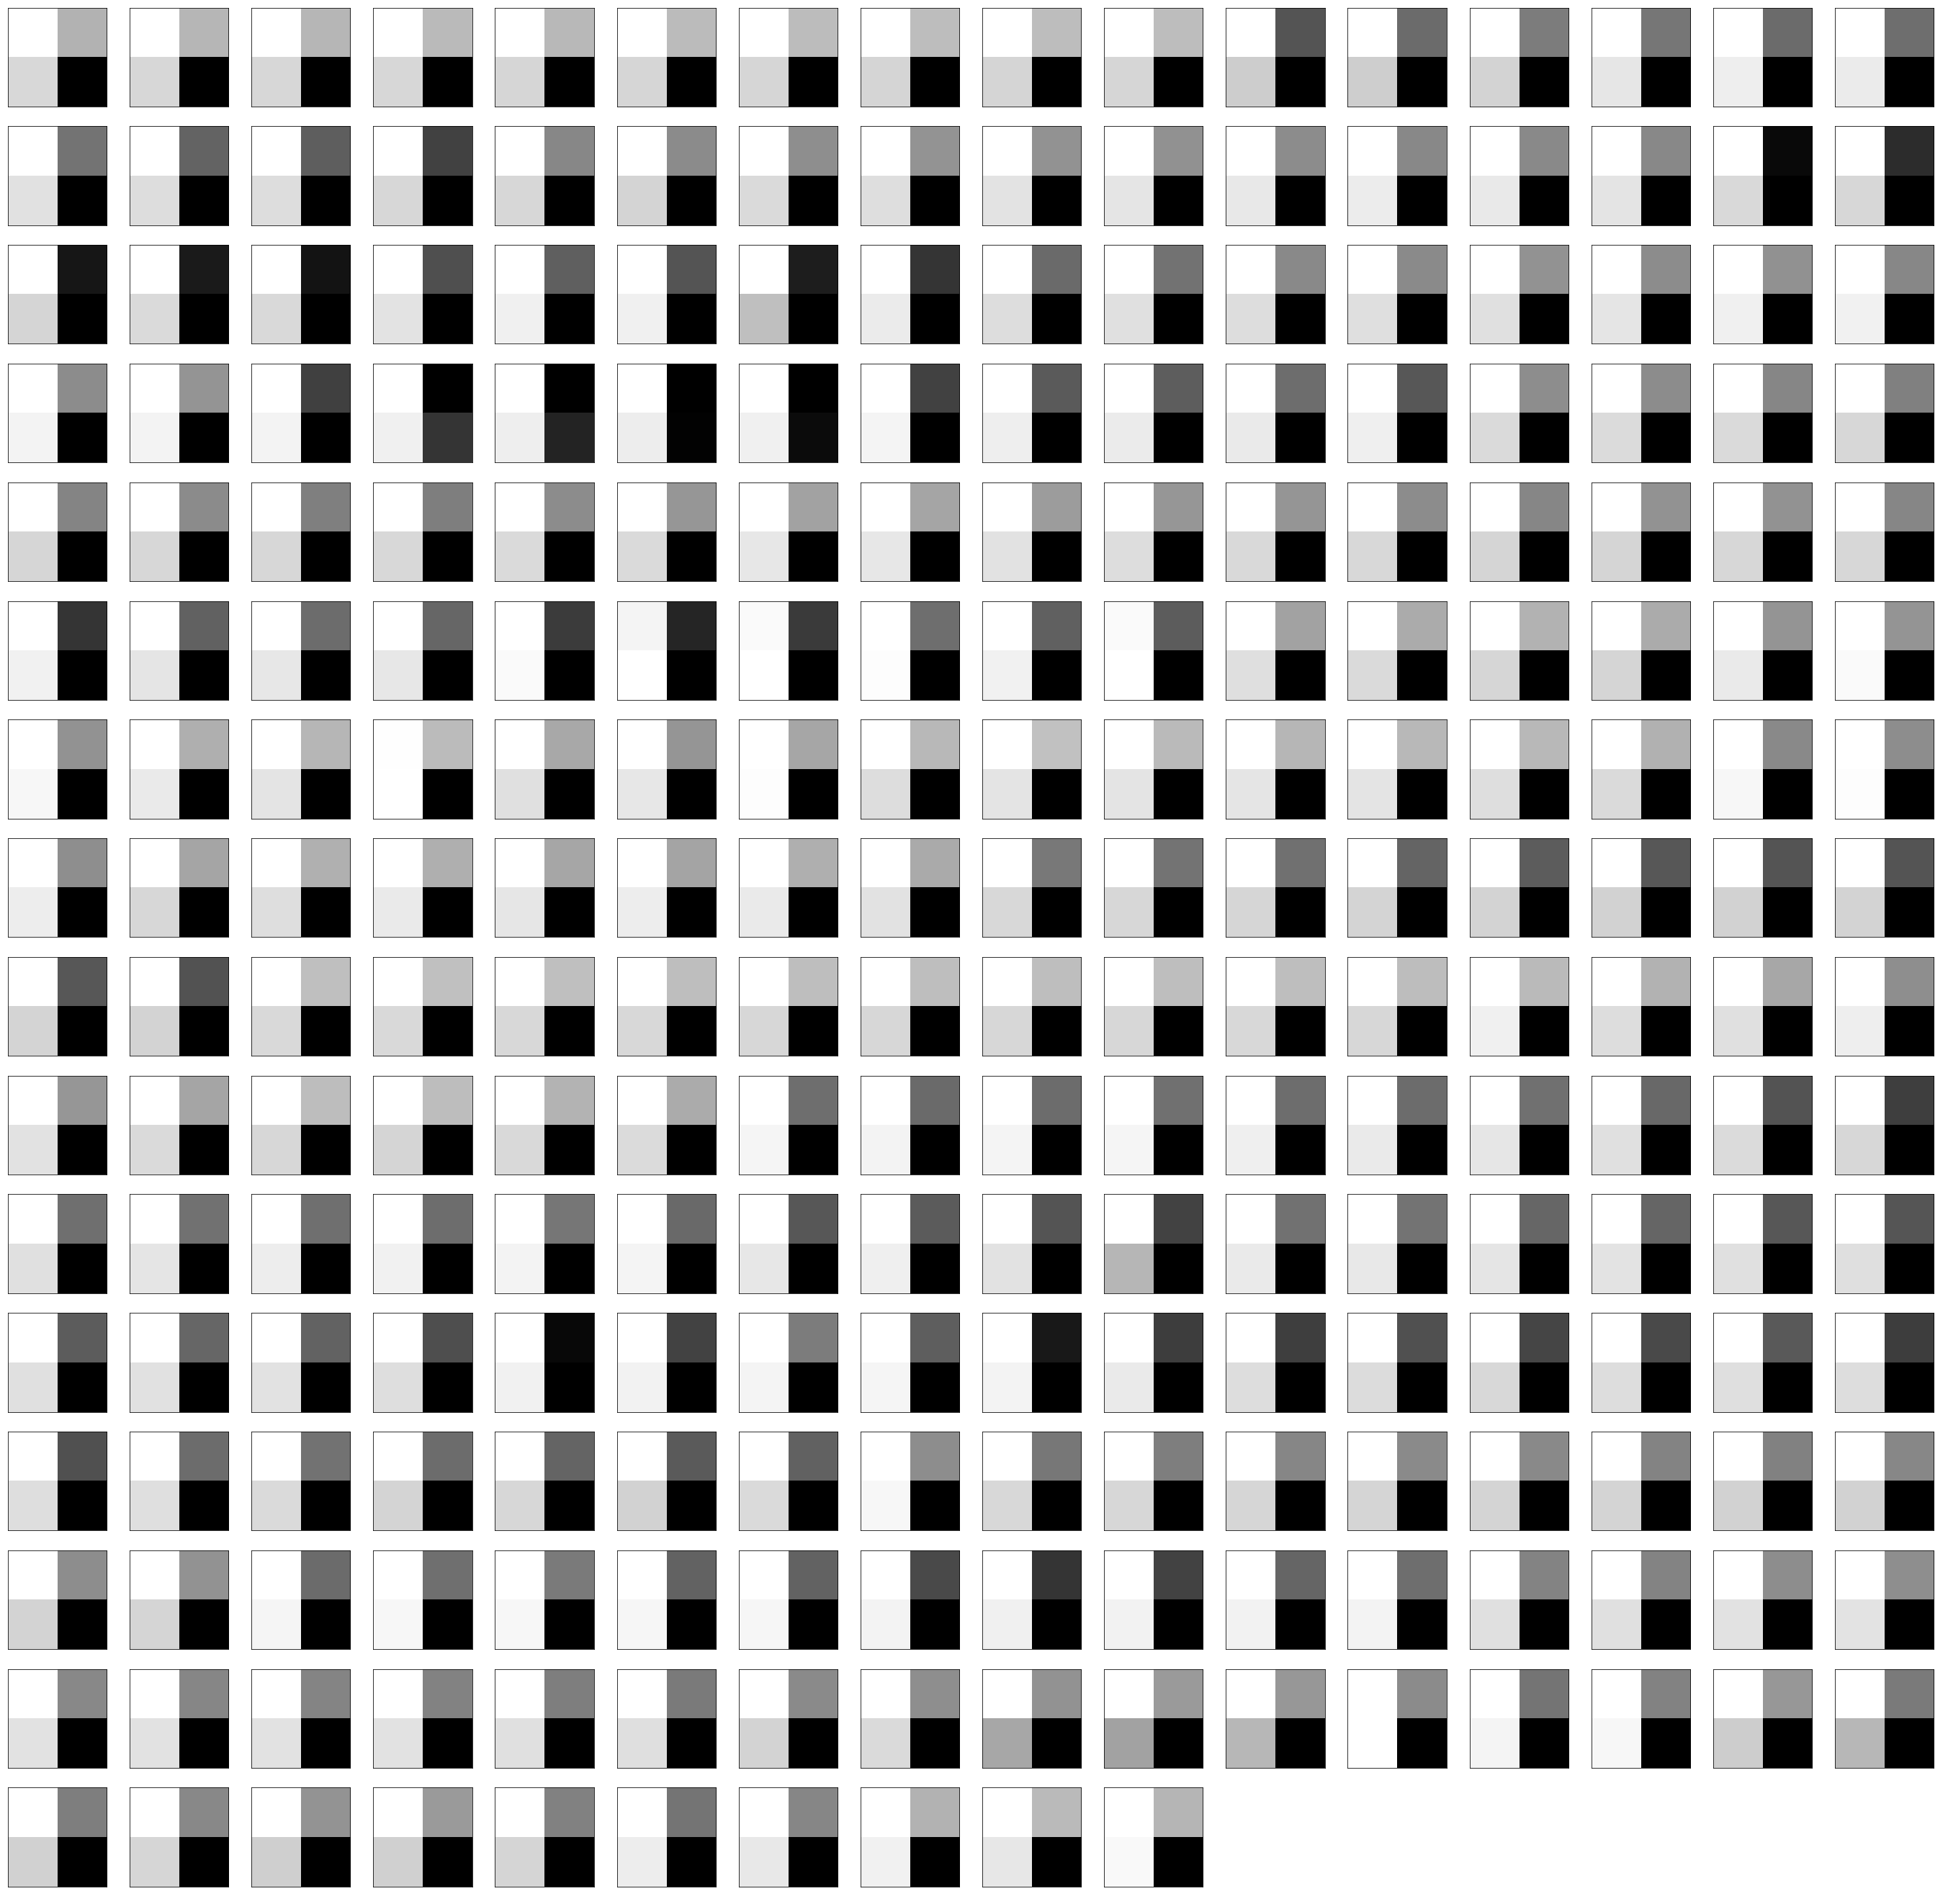

In [12]:
x4show = x4[:,0,:,:].view(-1,1,2,2).detach().numpy()
show_images_grid(x4show)

In [13]:
vae[0].fc_enc_mu(x4.view(-1,256)).shape

torch.Size([250, 4])

In [14]:
vae[0].fc_enc_mu_pred(x4.view(-1,256))

tensor([[-7.4409e-02,  3.2106e-02,  5.2898e-02, -1.9300e-03],
        [-7.4374e-02,  3.2450e-02,  5.3287e-02, -2.0240e-03],
        [-7.3980e-02,  3.2548e-02,  5.3558e-02, -2.1236e-03],
        [-7.3937e-02,  3.3012e-02,  5.3253e-02, -2.1895e-03],
        [-7.4329e-02,  3.3522e-02,  5.2827e-02, -2.3511e-03],
        [-7.4351e-02,  3.4067e-02,  5.2027e-02, -2.2849e-03],
        [-7.4793e-02,  3.4705e-02,  5.1946e-02, -2.2649e-03],
        [-7.5221e-02,  3.5364e-02,  5.1286e-02, -1.7974e-03],
        [-7.5111e-02,  3.5964e-02,  5.1517e-02, -1.4666e-03],
        [-7.5250e-02,  3.6607e-02,  5.1492e-02, -5.1766e-04],
        [-4.1386e-02,  3.7473e-02,  4.5634e-02, -1.1299e-02],
        [-4.4846e-02,  4.1181e-02,  4.8246e-02, -1.1078e-02],
        [-4.5484e-02,  3.7404e-02,  5.4089e-02, -1.2479e-02],
        [-4.1221e-02,  3.7993e-02,  5.4523e-02, -9.5774e-03],
        [-4.0224e-02,  3.8380e-02,  4.8489e-02, -4.7324e-03],
        [-4.3297e-02,  4.1546e-02,  4.2681e-02, -7.5399e-03],
        

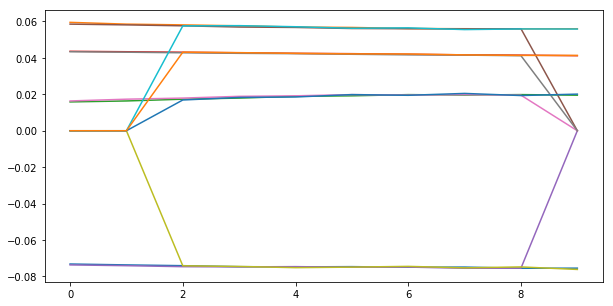

In [15]:
firstone = vae[0].fc_enc_mu(x4.view(-1,256)).view(25,10,n_latent)[:1,:,:]
firstone.shape

second = torch.zeros_like(firstone)
pred = torch.zeros_like(firstone)
second[:,:-1,:] = firstone[:,1:,:]
# second
pred[:,2:,:] = second[:,:-2,:] + (second[:,:-2,:]-firstone[:,:-2,:])
# pred[:,1:,:] = np.append(np.zeros((25,2,10)),pred[:,:-2,:],1)
pred

plt.figure(figsize=(10,5))
plt.plot(firstone.detach().numpy().reshape(-1,n_latent))
plt.plot(second.detach().numpy().reshape(-1,n_latent))
plt.plot(pred.detach().numpy().reshape(-1,n_latent))

In [16]:
gg=2
gamma = gamma_values[gg]

mu_enc,_,_ = vae[0].encode(x)
mu_enc = mu_enc.view(-1,vae[0].n_frames-1,n_latent)
mu_enc.shape
# first mu_pred is just mu_enc
mu_pred = torch.zeros_like(mu_enc)
mu = torch.zeros_like(mu_enc)
mu_pred[:,0,:] = mu_enc[:,0,:]
# as a consequence, first mu is also just mu_enc
mu[:,0,:] = mu_pred[:,0,:]
# second mu_pred is same as first mu_pred
mu_pred[:,1,:] = mu_pred[:,0,:]
for i in range(1,vae[0].n_frames-1):
    mu[:,i,:] = (1-gamma)*mu_enc[:,i,:] + gamma*mu_pred[:,i,:]
    if i < vae[0].n_frames-2:
        mu_pred[:,i+1,:] = 1*(mu[:,i,:] - mu[:,i-1,:]) + mu[:,i,:]

# mu1 = mu.view(-1,vae[0].n_frames,vae[0].n_latent)
# mu1.size(0)

gamma,1000*mu_enc[0,:,0],1000*mu_pred[0,:,0],1000*mu[0,:,0]

(0.4,
 tensor([-28.0184, -27.9758, -27.9542, -27.9950, -28.1552, -28.1382, -28.3339,
         -28.3150, -28.3067], grad_fn=<MulBackward0>),
 tensor([-28.0184, -28.0184, -27.9672, -27.9260, -27.9754, -28.1991, -28.2418,
         -28.4316, -28.4262], grad_fn=<MulBackward0>),
 tensor([-28.0184, -27.9928, -27.9594, -27.9674, -28.0833, -28.1625, -28.2971,
         -28.3616, -28.3545], grad_fn=<MulBackward0>))

In [17]:
recon,mu,mu_enc,mu_pred = vae[0].forward(x)
recon.size(),mu.size(),mu_enc.size(),mu_pred.size()

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(torch.Size([25, 9, 1, 32, 32]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]),
 torch.Size([25, 9, 4]))

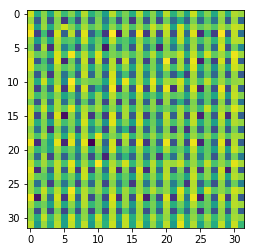

In [18]:
plt.imshow(recon[0][4][0].detach().numpy())

In [19]:
0.5*torch.sum((mu[:2,:]-mu_pred[:2,:])**2)

tensor(2.7790e-05, grad_fn=<MulBackward0>)

In [20]:
# %pdb on
reconstruction_loss(x, recon)

tensor(411.2334, grad_fn=<DivBackward0>)

In [21]:
# from main.py
from solver import Solver
import argparse

def str2bool(v):
    # codes from : https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse

    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser(description='inertia AE (autoencoder with representational inertia)')

parser.add_argument('--model', default='inertiaAE32', type=str, help='which model to train (inertiaAE32, inertiaAE64))')

parser.add_argument('--seed', default=1, type=int, help='random seed')
parser.add_argument('--cuda', default=True, type=str2bool, help='enable cuda')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--shuffle', default=True, type=str2bool, help='shuffle training data')
parser.add_argument('--max_iter', default=500000, type=int, help='number of training iterations')

parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--n_latent', default=4, type=int, help='dimension of the latent code')
parser.add_argument('--img_channels', default=1, type=int, help='number of image channels')

parser.add_argument('--gamma', default=1, type=float, help='gamma hyperparameter for the prediction contribution to inertia')

parser.add_argument('--dset_dir', default='data', type=str, help='dataset directory')
parser.add_argument('--dataset', default='dsprites_circle', type=str, help='dataset name')
parser.add_argument('--image_size', default=32, type=int, help='image size. now only (32,32) is supported')
parser.add_argument('--num_workers', default=6, type=int, help='dataloader num_workers')

parser.add_argument('--trainstats_gather_step', default=100, type=int, help='numer of iterations after which training stats are gathered and stored')
parser.add_argument('--trainstats_dir', default='trainstats', type=str, help='training statistics directory')

parser.add_argument('--display_step', default=100, type=int, help='number of iterations after which loss data is printed and visdom is updated')

parser.add_argument('--save_step', default=2000, type=int, help='number of iterations after which a checkpoint is saved')

parser.add_argument('--ckpt_dir', default='checkpoints', type=str, help='checkpoint directory')
parser.add_argument('--load_last_checkpoint', default=True, type=str2bool, help='load previous checkpoint if it exists')

_StoreAction(option_strings=['--load_last_checkpoint'], dest='load_last_checkpoint', nargs=None, const=None, default=True, type=<function str2bool at 0x7f9a10b34400>, choices=None, help='load previous checkpoint if it exists', metavar=None)

In [22]:
args = parser.parse_known_args()[0]

In [23]:
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [24]:
net = Solver(args)

=> no checkpoint found at 'checkpoints/inertiaae32_nlatent=4_gamma=1_dsprites_circle_last'


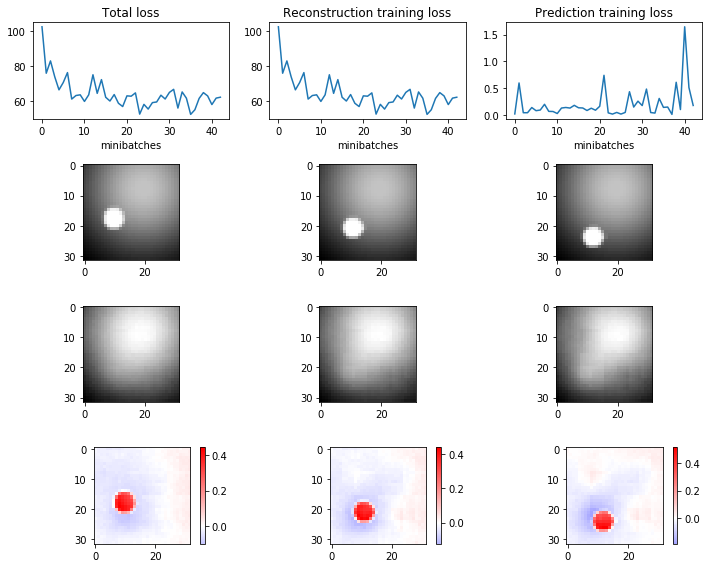

KeyboardInterrupt: 

In [25]:
net.train(plotmode=True)


In [ ]:
import importlib
importlib.reload(models)
from models import inertiaAE32, reconstruction_loss, prediction_loss
importlib.reload(solver)
from solver import Solver

In [ ]:
show_images_grid(dt[200000][0])

In [25]:
pwd

'/home/zaharia/projects/dgm/src/inertia_AE'